
### Clustering Analysis on a Customers Dataset
Consider that you possess a dataset of customer information, and your task is to perform customer segmentation on this historical data. Customer segmentation involves dividing a customer base into distinct groups based on shared characteristics. This approach is crucial because it allows a business to target specific groups effectively and optimize the allocation of marketing resources. For instance, one segment might consist of high-profit, low-risk customers—those more likely to make purchases or subscribe to services, whom the business aims to retain. Another segment could be customers from non-profit organizations, among others.

In this notebook, you will perform clustering analysis on the Mall Customers Dataset. This dataset includes the `Age`, `Annual Income` and `Spending Score` of customers. You will use K-Means and DBSCAN clustering algorithms to segment customers based on their behaviors and traits. The primary objective is to understand customer segments to tailor marketing strategies effectively.

---

#### Step 1: Data Loading and Initial Exploration
- Load the Mall Customers dataset from the following URL: 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/Cust_Segmentation.csv'.
- Use pandas to read the data and display the first few rows. 
- Generate basic statistics of the data using `.describe()`.


In [ ]:
import pandas as pd
import io
import requests
import numpy as np

# Load the data
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/Cust_Segmentation.csv'

s = requests.get(url).content
mall_customers = pd.read_csv(io.StringIO(s.decode('utf-8')))
mall_customers.head()


,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


In [ ]:
mall_customers.describe()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


In [ ]:

print(mall_customers.isna().sum())
mall_customers.dropna(inplace=True)

Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
Address              0
DebtIncomeRatio      0
dtype: int64


In [ ]:
mall_customers_df_copy = mall_customers.copy()

# since there are Na values in dataframe dropping them.
mall_customers_df_copy.dropna(inplace=True)

# Checking the data frame for Na values after dropping all Na values
mall_customers_df_copy.isna().sum()

Customer Id        0
Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
Address            0
DebtIncomeRatio    0
dtype: int64

#### Step 2: Data Preprocessing

- As observed, the "Address" field in this dataset is a categorical variable. The k-means algorithm, which relies on Euclidean distance, isn't suitable for categorical data because this type of distance measure doesn't make sense for discrete variables. Therefore, exclude this feature and proceed with the clustering analysis.
- Now  normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use __StandardScaler()__ to normalize our dataset.





In [ ]:
from sklearn.preprocessing import StandardScaler

# There are other categorical variables along with "Address" which are encoded as numeric in data such as Customer Id and Defaulted which can be dropped 
# in this analysis.
mall_customers_df_copy.drop(columns=['Address','Customer Id','Defaulted'],inplace=True)

# initializing the standard scaler and fitting the mall customers data
scaler = StandardScaler().fit(mall_customers_df_copy)

# Transforming the mall customers data using the scaler that is fitted for the data
mall_customers_scaled = scaler.transform(mall_customers_df_copy)

# After scaling converting the data back to data frame type from n dimension numpy array
mall_customers_scaled = pd.DataFrame(mall_customers_scaled,columns=mall_customers_df_copy.columns)

# Displaying the first 5 rows of scaled data using .head() method on the dataframe
mall_customers_scaled.head(5)



,Age,Edu,Years Employed,Income,Card Debt,Other Debt,DebtIncomeRatio
0,0.768304,0.298793,-0.359007,-0.723102,-0.675699,-0.604284,-0.580528
1,1.519090,-0.779325,2.647029,1.478707,1.431421,1.570620,0.372222
2,-0.232744,0.298793,0.242201,0.309845,2.154119,0.835201,1.559495
3,-0.733267,0.298793,-0.659610,-0.723102,-0.412427,-0.773833,-0.580528
4,1.519090,-0.779325,3.398538,5.637681,3.665215,1.780653,-0.448609


#### Step 3: Applying K-Means Clustering

- Apply K-Means clustering on the processed data. Choose a suitable number of clusters (start with `k=3`).
- Fit the model and then predict the cluster labels.
- Add these labels as a new column in the DataFrame and create a new DataFrame.
- Calculate the centroid value of each class.



c:\Users\srkna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\srkna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\srkna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\srkna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Text(0, 0.5, 'WSS')

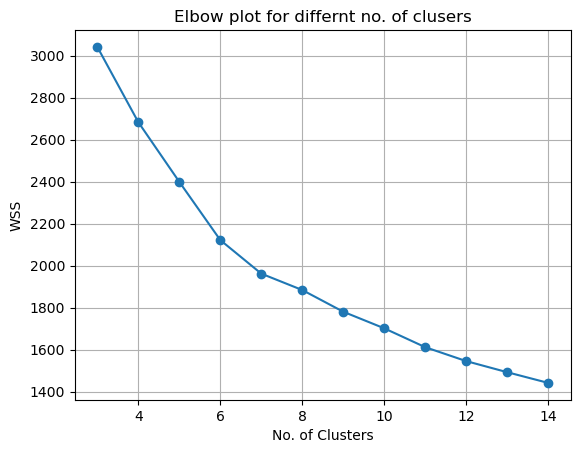

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# The following code is used to generate the Elbow method graph for identifying the 
# the optimal no. of clusters for Kmeans clustering.

# Create an empty list to append the inertia values for elbow graph
elbow_graph = []

# Iterating from 3 to 15 and calculating the inertia for clusters to plot the elbow graph
for i in range(3,15):
    Kmeans = KMeans(n_clusters=i,random_state=8)
    Kmeans.fit(mall_customers_scaled)
    elbow_graph.append(Kmeans.inertia_)

# Created the Elbow plot for the following data for diffferent no. of clusters

fig,ax = plt.subplots()
ax.plot(range(3,15),elbow_graph,marker='o')
# Displaying Grid on the graph
ax.grid()
ax.set_title("Elbow plot for differnt no. of clusers")
ax.set_xlabel('No. of Clusters')
ax.set_ylabel('WSS')

In [ ]:
''' 
Applying KMeans clustering algorithm with no. of clusters = 3 and Random_seed = 8
'''
# Initializing k-means clustering with no. of cluster = 3 and random seed = 8 
kmeans = KMeans(n_clusters=3, random_state=8)

# Trying to predict the labels from Kmeans and storing them into a variable named labels_from_kmeans
labels_from_kmeans = kmeans.fit_predict(mall_customers_scaled)

# Making a copy of data frame to create a new dataframe to add kmeans labels to it.
mall_customers_after_KMeans = mall_customers_df_copy.copy()
mall_customers_after_KMeans ['Labels_from_Kmeans'] = labels_from_kmeans

# Print the cluster centers as a numpy array.
i = 0
for center in kmeans.cluster_centers_:
    print("Cluster center for cluster {}".format(i), center) 
    i +=1 

Cluster center for cluster 0 [ 0.76934248 -0.15303268  0.68188002  0.29834072 -0.01000891  0.02439689
 -0.174857  ]
Cluster center for cluster 1 [-0.61131235  0.01147699 -0.62451421 -0.4899094  -0.33162644 -0.38842013
 -0.06557464]
Cluster center for cluster 2 [0.85300808 0.49782985 1.25731561 1.86344907 2.04727638 2.26396743
 1.04579913]


c:\Users\srkna\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


- Plot the results using a scatter plot. Use `Age` as the x-axis and `Income` as the y-axis. Color the points based on the cluster labels.
- Interpret the plot. What does each cluster seem to represent in terms of customer behavior?


Text(0, 0.5, 'Income')

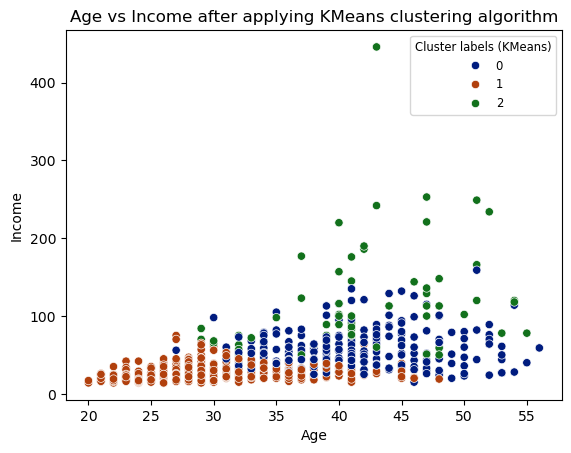

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig , ax  = plt.subplots()

# Using sns to create scatter plot 
sns.scatterplot(x='Age',y='Income',data=mall_customers_after_KMeans,hue='Labels_from_Kmeans',palette='dark',ax = ax)
# editing legend
ax.legend(title='Cluster labels (KMeans)',title_fontsize='small',fontsize='small')
ax.set_title("Age vs Income after applying KMeans clustering algorithm")
ax.set_xlabel("Age")
ax.set_ylabel("Income")

### What does cluster seem to represent in terms of customer behaviour?

From the clustering graph of Age vs income we tried forming 3 clusters where we have Cluster zero (coloured blue) which is spread from middle age to old age with a moderate income less than 125 (k$), cluster 1 (coloured orange) are mostly young and have an annual income less than 100 (K$) and Cluster 2 (Coloured green) who are mostly aged people have higher income more than 200 (k$) per year. There exist outliers in all clusters which might be influenced by factors other than Age and Income so they ended up being in smae cluster.

</Br>

#### Step 4: Applying DBSCAN Clustering
- Apply DBSCAN to the same dataset. Start with `eps=0.5` and `min_samples=5`.
- Fit the model and then predict the cluster labels.
- Determine the count of predicted classes. Adjust 'eps' and 'min_samples' to attain a total of three classes.
- Add these labels as a new column in your DataFrame and create a new DataFrame.

In [ ]:
from sklearn.cluster import DBSCAN

DBscan = DBSCAN(eps=0.5, min_samples=5)
DBscan.fit(mall_customers_scaled)

labels_dbscan = DBscan.labels_

# Calculating no. of clusters
no_of_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
# Calculating no. of noise points
no_of_noise_points = list(labels_dbscan).count(-1)

print("No. of noise points = ", no_of_noise_points)
print("No. of Clusters in DBSCAN = ",no_of_clusters_dbscan)


No. of noise points =  534
No. of Clusters in DBSCAN =  5


In [10]:
'''
    In the following for loop the eps is varied from 0.6 to 2 with an interval of 0.1 and
    min_samples is changed from 5 to 10 for obtaining the count of clusters = 3
'''
for i in np.arange(0.6, 2, 0.2):
    for j in range(5, 10):
        dbscan = DBSCAN(eps=i, min_samples=j)
        dbscan.fit(mall_customers_scaled)

        labels_dbscan = dbscan.labels_

        # Count number of clusters and noise points
        no_of_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
        no_of_noise_points = list(labels_dbscan).count(-1)
        
        # Break when we have exactly 3 clusters
        if no_of_clusters_dbscan == 3:
            print(f"eps: {i}, min_samples: {j}")
            break
    if no_of_clusters_dbscan == 3:
        break

# creating a new copy of data frame for DBSCAN and adding the coloum 'Labels_from_DBSCAN' to the data frame.
mall_customers_after_DBSCAN = mall_customers.copy()
mall_customers_after_DBSCAN['labels_from_dbsacan'] = labels_dbscan


print("Value of eps for forming 3 clusters :", i)
print("Value of min_samples for forming 3 clusters :", j)

eps: 0.8, min_samples: 7
Value of eps for forming 3 clusters : 0.8
Value of min_samples for forming 3 clusters : 7


In [11]:
# Printing the no. of noise points and the total clusters formed
print("No. of noise points = ", no_of_noise_points)
print("No. of Clusters in DBSCAN = ",no_of_clusters_dbscan)

No. of noise points =  329
No. of Clusters in DBSCAN =  3


- Plot the results using the same scatter plot setup as in Exercise 4.
- Compare the results with K-Means. How does DBSCAN differ in terms of cluster formation?

Text(0, 0.5, 'Income')

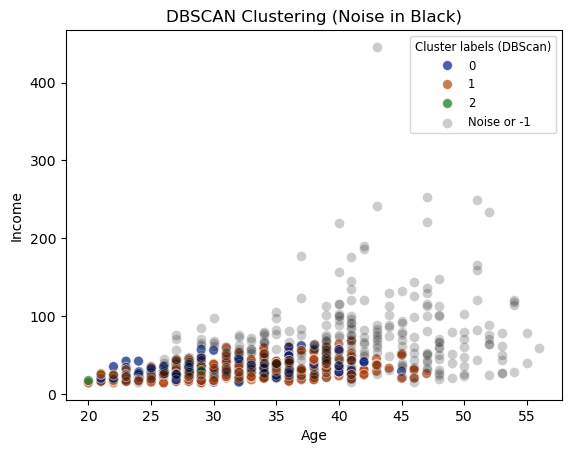

In [ ]:
fig , ax = plt.subplots()

# Plotting the Data with class labels except the noise points 
sns.scatterplot(x='Age', y='Income', hue='labels_from_dbsacan', data=mall_customers_after_DBSCAN[mall_customers_after_DBSCAN['labels_from_dbsacan']!=-1 ],palette='dark', s=50, alpha=0.7)

# Colouring noise points with black
noise_points = mall_customers_after_DBSCAN[mall_customers_after_DBSCAN['labels_from_dbsacan'] == -1]
# Plotiing the noise points using sns library
sns.scatterplot(x='Age', y='Income',data = noise_points, color='black', label='Noise or -1', s=50, alpha=0.2)
plt.legend(title = "Cluster labels (DBScan)",title_fontsize= 'small',fontsize='small')
plt.title('DBSCAN Clustering (Noise in Black)')
plt.xlabel('Age')
plt.ylabel('Income')


<h3>Comparision of results between KMeans and DBSCAN</h3>

On comparing Kmeans clustering with DBSCAN, There is no significant clustering visible after applying DBSCAN when the parameters are configured for 3 clusters (eps = 0.8 and min_samples = 7). From the graph plotted between age and income, it is tough to draw the conclusions from the clusters formed about customers behaviour. We can see there are around 329 noise points which are plotted in the graph with alpha 0.2 in black.

Comparing the plot with KMeans, KMeans tried to assign every data point to a cluster whereas in DBSCAN the points which are not dense are marked as noise points. Hence the DBSCAN algorithm is resistant to outliers where as the the KMeans is outlier sensitive.

#### Step 5: Evaluation and Interpretation
- Calculate and compare the silhouette scores for both K-Means and DBSCAN.
- Discuss the strengths and weaknesses of each clustering method based on the dataset and the results obtained.

In [13]:
from sklearn.metrics import silhouette_score

# Write your code here

# Silhoutte score calculation for DBScan and Kmeans using Euclidean metrics
Silhouette_coefficient_DBSCAN = silhouette_score(mall_customers_scaled, labels_dbscan, metric='euclidean')

Silhouette_coefficient_Kmeans = silhouette_score(mall_customers_scaled, labels_from_kmeans, metric='euclidean')

print("Silhoutte score for DBSCAN clustering algorithm :", Silhouette_coefficient_DBSCAN)
print("Silhoutte score for KMeans clustering algorithm :", Silhouette_coefficient_Kmeans)

Silhoutte score for DBSCAN clustering algorithm : 0.0005080629646946073
Silhoutte score for KMeans clustering algorithm : 0.22164774815048738


<h3>Strengths and Weaknesses of the KMeans Algorithm </h3>

<h4> Strengths </h4>

- From the graph of Age vs Income for KMeans, the clusters appear to be better and there is clear seperation between them. Though they have outliers it was possible to interpret the classes.
- For the given dataset the silhoutte score achieved by the Kmeans clustering is higher than the DBSCAN clustering.
<h4> Weaknesses </h4>

- KMeans algorithm is sensitive to outliers as it also includes outliers in clustering, from the graph it is clear that there is person who is earning more than 400k$ and is classified into class 2.
- We must go for trail and error method to determine the accurate value of K (number of clusters). Though there are methods such as elbow graph method it is determing accurate K value is always subjective.

</br>
</br>
<h3>Strengths and Weaknesses of the DBSCAN Algorithm </h3>
<h4> Strengths </h4>

- In DBSCAN algorithm the data points that are not dense (the outliers) are not included in the clusters and are marked as noise points with a class label of negative 1 (-1). The algorithm is resistant to the outliers.
- In DBSCAN algorithm the shapes of the clusters can be arbitary in contrary to that of K-Means which supports mostly gobular shapes.
- The no. of clusters formed in the dataset is determined by the algorithm and it is not predefined by the user.
<h4> Weaknesses </h4>

- For the given dataset DBSCAN algorithm resulted in poor silhoutte score of 0.0005, this implies that the clusters are not clearly seperated.
- DBSCAN is also highly sensitive to the initialization parameters (eps and min_samples) finding the right set of parameters for is dataset goes by trail, error and evaluation method.
